# Imports

In [1]:
from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

# Configs

In [2]:
BASE_PATH = "/Users/maedeh/Desktop/data/"

LABELED_PATH = BASE_PATH + "labels_phase2.parquet"
XGB_MODEL_PATH = BASE_PATH + "XGB_predictions_loc_phase2.parquet"
RIDGE_MODEL_PATH = BASE_PATH + "Ridge_predictions_loc_phase2.parquet"
RF_RIDGE_MODEL_PATH = BASE_PATH + "RF_ridge_predictions_loc_phase2.parquet"

SAVE_PLOT_PATH = BASE_PATH + 'pngs/'


MODEL_LIST = ['BASELINE_LAST_WEEK', 'RIDGE_MODEL', 'XGB_MODEL', 'RF_RIDGE_MODEL']
CATEGORIES = ['high_demand_locations', 'low_demand_locations']
METRICS = ['MAPE', 'MAE', 'RMSE']
BASED_ON = ['Location', 'Date', 'Hour_interval', 'Day_of_week']


TEST_START_DATE = '2023-04-01'
LAST_WEEK_TEST_START_DATE = '2023-03-25'


NUM_INTERVAL_PER_DAY = 8
HIGH_DEMAND_NUMS = 55
SORT_METHOD = 'mean'



warnings.filterwarnings('ignore')

In [3]:
report_dict = {cat:{met:{model:None for model in MODEL_LIST} for met in METRICS} for cat in CATEGORIES}
predictions_dict = {model:None for model in MODEL_LIST}
sorted_locations_dict={cat:None for cat in CATEGORIES}
predictions_mean_error_dict={model:{based:{cat:None for cat in CATEGORIES} for based in BASED_ON} for model in MODEL_LIST}

# Load Data

## Load labeled data

In [4]:
labeled_df = pd.read_parquet(LABELED_PATH)
print(labeled_df.shape)
labeled_df.head()

(251520, 4)


,Location,Date,Hour_interval,Demand
0,1,2023-01-01,0,0.0
1,1,2023-01-01,3,1.0
2,1,2023-01-01,6,1.0
3,1,2023-01-01,9,1.0
4,1,2023-01-01,12,13.0


In [5]:
test_df = labeled_df.loc[labeled_df['Date']>=TEST_START_DATE]
test_df = test_df.reset_index(drop = True)
print(test_df.shape)
test_df.head()

(62880, 4)


,Location,Date,Hour_interval,Demand
0,1,2023-04-01,0,0.0
1,1,2023-04-01,3,1.0
2,1,2023-04-01,6,1.0
3,1,2023-04-01,9,0.0
4,1,2023-04-01,12,1.0


## Load Predicted Data

In [6]:
for model in MODEL_LIST:
    if model != 'BASELINE_LAST_WEEK':
        predictions_dict[model] = pd.read_parquet(eval(model + '_PATH'))
        print(f"shape of {model} {predictions_dict[model].shape}")
        display(predictions_dict[model].head())

shape of RIDGE_MODEL (9900, 4)


,Location,Date,Hour_interval,Predicted_demand
0,13,2023-04-01,0,12.206882
1,13,2023-04-02,0,9.036611
2,13,2023-04-03,0,5.426939
3,13,2023-04-04,0,5.899058
4,13,2023-04-05,0,5.604295


shape of XGB_MODEL (13200, 4)


,Location,Date,Hour_interval,Predicted_demand
0,13,2023-04-01,0,7.199490
1,13,2023-04-01,3,3.967424
2,13,2023-04-01,6,18.584469
3,13,2023-04-01,9,83.804619
4,13,2023-04-01,12,130.793304


shape of RF_RIDGE_MODEL (13200, 4)


,Location,Date,Hour_interval,Predicted_demand
0,13,2023-04-01,0,8.259554
1,13,2023-04-01,3,4.200599
2,13,2023-04-01,6,20.009753
3,13,2023-04-01,9,86.013368
4,13,2023-04-01,12,134.801747


### BaseLine Models

In [7]:
def baseline_predict(dataset, shift_val):
    baseline_test_df = dataset.loc[dataset['Date']>=LAST_WEEK_TEST_START_DATE]
    baseline_test_df = baseline_test_df.reset_index(drop = True)
    predicted_demand = baseline_test_df.groupby(['Location'])['Demand'].shift(shift_val)
    predicted_data = pd.DataFrame(baseline_test_df[['Location', 'Date', 'Hour_interval']])
    predicted_data['Predicted_demand'] = predicted_demand
    predicted_data = predicted_data.dropna()
    return predicted_data

In [8]:
predictions_dict['BASELINE_LAST_WEEK'] = baseline_predict(labeled_df, 7*NUM_INTERVAL_PER_DAY)
print(predictions_dict['BASELINE_LAST_WEEK'].shape)
predictions_dict['BASELINE_LAST_WEEK'].head()

(62880, 4)


,Location,Date,Hour_interval,Predicted_demand
56,1,2023-04-01,0,0.0
57,1,2023-04-01,3,0.0
58,1,2023-04-01,6,3.0
59,1,2023-04-01,9,2.0
60,1,2023-04-01,12,3.0


### Join Predictions and Actual

In [9]:
def join_actual_predict(actual_df, predicted_df):
    for label,predictions_df in predicted_df.items():
        if (predictions_df is not None):
            actual_predicted_df = actual_df.merge(predictions_df, how='left', on=['Location', 'Date', 'Hour_interval'])
            actual_predicted_df['Date'] = pd.to_datetime(actual_predicted_df['Date'])
            actual_predicted_df['Day_of_week'] = actual_predicted_df['Date'].dt.dayofweek
            predictions_dict[label] = actual_predicted_df

In [10]:
join_actual_predict(test_df,predictions_dict)
for model in MODEL_LIST:
    print(f"shape of predictions_dict[{model}]: {predictions_dict[model].shape}")
    display(predictions_dict[model].head())

shape of predictions_dict[BASELINE_LAST_WEEK]: (62880, 6)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,0,0.0,0.0,5
1,1,2023-04-01,3,1.0,0.0,5
2,1,2023-04-01,6,1.0,3.0,5
3,1,2023-04-01,9,0.0,2.0,5
4,1,2023-04-01,12,1.0,3.0,5


shape of predictions_dict[RIDGE_MODEL]: (62880, 6)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,0,0.0,NaN,5
1,1,2023-04-01,3,1.0,NaN,5
2,1,2023-04-01,6,1.0,NaN,5
3,1,2023-04-01,9,0.0,NaN,5
4,1,2023-04-01,12,1.0,NaN,5


shape of predictions_dict[XGB_MODEL]: (62880, 6)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,0,0.0,NaN,5
1,1,2023-04-01,3,1.0,NaN,5
2,1,2023-04-01,6,1.0,NaN,5
3,1,2023-04-01,9,0.0,NaN,5
4,1,2023-04-01,12,1.0,NaN,5


shape of predictions_dict[RF_RIDGE_MODEL]: (62880, 6)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,0,0.0,NaN,5
1,1,2023-04-01,3,1.0,NaN,5
2,1,2023-04-01,6,1.0,NaN,5
3,1,2023-04-01,9,0.0,NaN,5
4,1,2023-04-01,12,1.0,NaN,5


### Sort Locations by Demand

In [11]:
def sort_locations_on_demand(predictions_dict,sorted_locations_dict):
    predictions_df = predictions_dict['BASELINE_LAST_WEEK']
    if (predictions_df is not None):
        category_index = predictions_df.groupby(['Location'])['Demand'].aggregate([SORT_METHOD]).sort_values(SORT_METHOD,ascending=False).reset_index()
        category_df = predictions_df.merge(category_index[:HIGH_DEMAND_NUMS], how='right', on=['Location'])
        category_min_df = category_df.groupby(['Location','Hour_interval']).agg(Min=('Demand','min')).sort_values(by='Min',ascending=False).reset_index()
        low_index=category_min_df[category_min_df['Min'].isin([0])]
        high_index=category_min_df[~category_min_df['Min'].isin([0])]
        category_df = category_df[['Location','Hour_interval',SORT_METHOD]].drop_duplicates()
        sorted_locations_dict['high_demand_locations']=category_df.merge(high_index[['Location','Hour_interval']], on=['Location','Hour_interval'])
        sorted_locations_dict['low_demand_locations']=category_df.merge(low_index[['Location','Hour_interval']], on=['Location','Hour_interval'])
        

In [12]:
sort_locations_on_demand(predictions_dict, sorted_locations_dict)
for cat in CATEGORIES:
    print(f"shape of sorted_locations_dict[{cat}]: {sorted_locations_dict[cat].shape}")
    display(sorted_locations_dict[cat].head())

shape of sorted_locations_dict[high_demand_locations]: (429, 3)


,Location,Hour_interval,mean
0,132,0,722.3125
1,132,3,722.3125
2,132,6,722.3125
3,132,9,722.3125
4,132,12,722.3125


shape of sorted_locations_dict[low_demand_locations]: (11, 3)


,Location,Hour_interval,mean
0,144,3,119.795833
1,211,3,107.037500
2,13,0,75.358333
3,13,3,75.358333
4,125,3,69.058333


# Mean error Calculation

### Error Columns

In [13]:
def calculate_error(actual_predicted_dict: dict):
    for label,actual_predicted_df in actual_predicted_dict.items():
        if (actual_predicted_df is not None):
            
            actual_predicted_df['error'] = np.abs(
                actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand']
                )
            
            actual_predicted_df['squared_error'] = np.square(
                actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand']
                )
            
            actual_Demand_df = np.where(actual_predicted_df['Demand']==0, 1, actual_predicted_df['Demand'])
            # actual_Demand_df = actual_predicted_df['Demand']+1
            actual_predicted_df['percentage_error'] = (
                actual_predicted_df['error']/actual_Demand_df
                )*100
            

In [14]:
calculate_error(predictions_dict)
for model in MODEL_LIST:
    print(f"shape of predictions_dict[{model}]: {predictions_dict[model].shape}")
    display(predictions_dict[model].head())

shape of predictions_dict[BASELINE_LAST_WEEK]: (62880, 9)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,0,0.0,0.0,5,0.0,0.0,0.0
1,1,2023-04-01,3,1.0,0.0,5,1.0,1.0,100.0
2,1,2023-04-01,6,1.0,3.0,5,2.0,4.0,200.0
3,1,2023-04-01,9,0.0,2.0,5,2.0,4.0,200.0
4,1,2023-04-01,12,1.0,3.0,5,2.0,4.0,200.0


shape of predictions_dict[RIDGE_MODEL]: (62880, 9)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,0,0.0,NaN,5,NaN,NaN,NaN
1,1,2023-04-01,3,1.0,NaN,5,NaN,NaN,NaN
2,1,2023-04-01,6,1.0,NaN,5,NaN,NaN,NaN
3,1,2023-04-01,9,0.0,NaN,5,NaN,NaN,NaN
4,1,2023-04-01,12,1.0,NaN,5,NaN,NaN,NaN


shape of predictions_dict[XGB_MODEL]: (62880, 9)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,0,0.0,NaN,5,NaN,NaN,NaN
1,1,2023-04-01,3,1.0,NaN,5,NaN,NaN,NaN
2,1,2023-04-01,6,1.0,NaN,5,NaN,NaN,NaN
3,1,2023-04-01,9,0.0,NaN,5,NaN,NaN,NaN
4,1,2023-04-01,12,1.0,NaN,5,NaN,NaN,NaN


shape of predictions_dict[RF_RIDGE_MODEL]: (62880, 9)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,0,0.0,NaN,5,NaN,NaN,NaN
1,1,2023-04-01,3,1.0,NaN,5,NaN,NaN,NaN
2,1,2023-04-01,6,1.0,NaN,5,NaN,NaN,NaN
3,1,2023-04-01,9,0.0,NaN,5,NaN,NaN,NaN
4,1,2023-04-01,12,1.0,NaN,5,NaN,NaN,NaN


### Aggregate Error Columns

In [15]:
def calculate_mean_error(actual_predicted_dict: dict, predictions_mean_dict: dict):
    for model,actual_predicted_df in actual_predicted_dict.items():
        if (actual_predicted_df is not None):
            for cat in CATEGORIES:
                sorted_locations = sorted_locations_dict[cat]
                categorized_df = actual_predicted_df.merge(sorted_locations[['Location', 'Hour_interval']], on=['Location','Hour_interval'])
                for per in BASED_ON:
                    categorized_error_df = categorized_df[[per,'Demand','error','squared_error', 'percentage_error']]
                    categorized_mean_df = (
                        categorized_error_df.groupby(per).agg(mape=('percentage_error','mean'),
                                                              mae=('error','mean'),
                                                              mse=('squared_error','mean'),
                                                              demand_mean=('Demand','mean'))
                                                              ) 
                    categorized_mean_df['rmse'] = np.sqrt(categorized_mean_df['mse'])
                    categorized_mean_df.drop(columns='mse', inplace=True)
                    categorized_mean_df['mape'] = np.where(categorized_mean_df['mape']>100, 100, categorized_mean_df['mape'])
                    if per == 'Location':
                        loc_demand_index = sorted_locations.groupby(['Location'])[SORT_METHOD].sum().sort_values(ascending=False).index
                        categorized_mean_df = categorized_mean_df.reindex(loc_demand_index)
                    if per == 'Hour_interval':
                        hour_demand_index = sorted_locations.groupby(['Hour_interval'])[SORT_METHOD].sum().sort_values(ascending=False).index
                        categorized_mean_df = categorized_mean_df.reindex(hour_demand_index)
            
                    predictions_mean_dict[model][per][cat] = categorized_mean_df.reset_index()
                        


In [16]:
calculate_mean_error(predictions_dict, predictions_mean_error_dict)
for model in MODEL_LIST:
    for per in BASED_ON:
        for cat in CATEGORIES:
            print(f"shape of predictions_mean_dict[{model}][{per}][{cat}]: {predictions_mean_error_dict[model][per][cat].shape}")
            display(predictions_mean_error_dict[model][per][cat].head())

shape of predictions_mean_dict[BASELINE_LAST_WEEK][Location][high_demand_locations]: (55, 5)


,Location,mape,mae,demand_mean,rmse
0,132,18.087126,96.437500,722.312500,134.945437
1,237,16.621162,70.704167,640.745833,99.491478
2,161,14.992237,58.808333,621.241667,83.844549
3,236,19.444128,77.600000,576.316667,109.358889
4,142,19.899866,64.316667,472.700000,93.465368


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Location][low_demand_locations]: (8, 5)


,Location,mape,mae,demand_mean,rmse
0,13,68.587302,2.166667,4.016667,2.943920
1,144,32.929334,8.400000,38.766667,14.848120
2,211,72.392427,6.300000,21.100000,8.856260
3,88,74.135640,2.650000,6.200000,3.589336
4,125,48.978377,4.433333,16.500000,6.483312


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Date][high_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,17.738776,34.326340,264.993007,55.738818
1,2023-04-02,18.141553,26.708625,225.764569,43.302912
2,2023-04-03,20.919792,31.296037,220.170163,55.378924
3,2023-04-04,21.241840,27.384615,246.855478,45.979878
4,2023-04-05,21.851159,41.310023,263.482517,66.484062


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Date][low_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,22.603030,3.272727,23.454545,5.752470
1,2023-04-02,36.303039,6.909091,20.272727,14.308294
2,2023-04-03,84.608725,1.909091,4.090909,2.393172
3,2023-04-04,83.982684,1.181818,3.272727,1.623688
4,2023-04-05,78.636364,1.909091,3.454545,2.276361


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Hour_interval][high_demand_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,9,13.682871,29.671515,272.877576,45.271009
1,12,12.561447,34.357576,337.763030,51.698602
2,15,13.968916,42.610303,374.358182,63.748602
3,18,17.960684,54.371515,371.287879,79.694656
4,21,20.578173,49.226667,292.476364,78.831589


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Hour_interval][low_demand_locations]: (3, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,3,73.606300,3.479167,10.995833,6.802879
1,0,69.396825,2.300000,4.500000,3.331666
2,6,64.119767,2.983333,7.050000,3.792537


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Day_of_week][high_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,23.316252,29.189977,218.457459,50.886019
1,1,20.015836,27.787879,251.393357,46.103360
2,2,21.266335,33.261072,266.130536,54.913972
3,3,20.046242,35.257576,273.421911,58.574191
4,4,19.534388,36.460956,267.082168,61.259893


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Day_of_week][low_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,67.239475,1.818182,4.000000,2.713602
1,1,83.306277,1.545455,3.181818,2.163751
2,2,68.928701,1.568182,3.181818,2.301185
3,3,69.680235,2.204545,4.727273,2.880183
4,4,65.322122,3.386364,9.636364,4.245318


shape of predictions_mean_dict[RIDGE_MODEL][Location][high_demand_locations]: (55, 5)


,Location,mape,mae,demand_mean,rmse
0,132,11.653687,84.954603,722.312500,112.004957
1,237,13.144621,66.227495,640.745833,88.704002
2,161,12.349128,61.140461,621.241667,79.179804
3,236,13.914372,66.754884,576.316667,93.014201
4,142,15.221362,61.745659,472.700000,85.047459


shape of predictions_mean_dict[RIDGE_MODEL][Location][low_demand_locations]: (8, 5)


,Location,mape,mae,demand_mean,rmse
0,13,86.479475,2.429022,4.016667,3.272128
1,144,NaN,NaN,38.766667,NaN
2,211,NaN,NaN,21.100000,NaN
3,88,NaN,NaN,6.200000,NaN
4,125,NaN,NaN,16.500000,NaN


shape of predictions_mean_dict[RIDGE_MODEL][Date][high_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,15.721848,34.175173,264.993007,46.952098
1,2023-04-02,16.259618,29.626419,225.764569,43.330561
2,2023-04-03,35.921895,31.618335,220.170163,48.496671
3,2023-04-04,19.000204,26.886010,246.855478,42.675480
4,2023-04-05,21.483830,46.312765,263.482517,69.861744


shape of predictions_mean_dict[RIDGE_MODEL][Date][low_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,1.724018,0.206882,23.454545,0.206882
1,2023-04-02,12.957640,1.036611,20.272727,1.036611
2,2023-04-03,100.000000,4.426939,4.090909,4.426939
3,2023-04-04,47.476439,1.899058,3.272727,1.899058
4,2023-04-05,12.085897,0.604295,3.454545,0.604295


shape of predictions_mean_dict[RIDGE_MODEL][Hour_interval][high_demand_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,9,11.087225,23.521148,272.877576,35.256742
1,12,10.708170,29.197924,337.763030,42.905749
2,15,11.969413,36.728619,374.358182,54.368096
3,18,13.758248,41.143993,371.287879,59.647665
4,21,17.848781,40.827135,292.476364,64.905183


shape of predictions_mean_dict[RIDGE_MODEL][Hour_interval][low_demand_locations]: (3, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,3,NaN,NaN,10.995833,NaN
1,0,86.479475,2.429022,4.500000,3.272128
2,6,NaN,NaN,7.050000,NaN


shape of predictions_mean_dict[RIDGE_MODEL][Day_of_week][high_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,27.560424,29.854387,218.457459,46.882818
1,1,18.400222,24.873493,251.393357,39.018637
2,2,16.372054,31.637812,266.130536,49.749260
3,3,15.244232,34.648114,273.421911,54.013242
4,4,13.410401,32.633680,267.082168,51.107990


shape of predictions_mean_dict[RIDGE_MODEL][Day_of_week][low_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,100.000000,1.978977,4.000000,2.479852
1,1,81.612406,1.327980,3.181818,1.610937
2,2,40.248332,0.774834,3.181818,0.921982
3,3,100.000000,3.467233,4.727273,3.967299
4,4,66.043359,3.049198,9.636364,3.621770


shape of predictions_mean_dict[XGB_MODEL][Location][high_demand_locations]: (55, 5)


,Location,mape,mae,demand_mean,rmse
0,132,12.858092,73.707457,722.312500,100.276344
1,237,12.751379,58.742670,640.745833,81.061027
2,161,12.989982,46.281084,621.241667,65.585286
3,236,14.035243,60.022959,576.316667,86.516619
4,142,14.659013,50.749956,472.700000,76.057635


shape of predictions_mean_dict[XGB_MODEL][Location][low_demand_locations]: (8, 5)


,Location,mape,mae,demand_mean,rmse
0,13,72.226671,1.901121,4.016667,2.320866
1,144,59.202735,5.096997,38.766667,7.960668
2,211,73.697971,4.524129,21.100000,6.339896
3,88,71.345413,2.191386,6.200000,2.943310
4,125,45.338226,2.489732,16.500000,3.385791


shape of predictions_mean_dict[XGB_MODEL][Date][high_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,13.952528,23.264899,264.993007,35.491379
1,2023-04-02,15.565641,21.332000,225.764569,34.517114
2,2023-04-03,19.348199,23.723495,220.170163,39.581526
3,2023-04-04,17.740489,21.679821,246.855478,35.991993
4,2023-04-05,17.643353,35.584534,263.482517,58.491245


shape of predictions_mean_dict[XGB_MODEL][Date][low_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,33.196266,5.925208,23.454545,9.954365
1,2023-04-02,37.869517,3.857388,20.272727,7.522190
2,2023-04-03,100.000000,1.830373,4.090909,2.310150
3,2023-04-04,87.249252,1.256473,3.272727,1.515123
4,2023-04-05,65.249076,1.213297,3.454545,1.648379


shape of predictions_mean_dict[XGB_MODEL][Hour_interval][high_demand_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,9,10.428909,23.436958,272.877576,34.791721
1,12,10.173188,28.921635,337.763030,42.636337
2,15,11.448491,35.942136,374.358182,53.529936
3,18,13.037630,38.664766,371.287879,55.887248
4,21,16.170358,37.792657,292.476364,60.718170


shape of predictions_mean_dict[XGB_MODEL][Hour_interval][low_demand_locations]: (3, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,3,73.022739,2.544821,10.995833,4.283911
1,0,82.133549,2.167575,4.500000,2.620422
2,6,65.129878,3.048355,7.050000,3.745084


shape of predictions_mean_dict[XGB_MODEL][Day_of_week][high_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,21.585755,25.444123,218.457459,42.222901
1,1,16.196442,21.100862,251.393357,35.564446
2,2,16.283450,25.044145,266.130536,41.516726
3,3,15.668362,28.141498,273.421911,46.026669
4,4,15.478619,28.971836,267.082168,47.109432


shape of predictions_mean_dict[XGB_MODEL][Day_of_week][low_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,99.406571,1.923786,4.000000,2.515249
1,1,74.059431,1.301720,3.181818,1.730743
2,2,87.067945,1.549464,3.181818,1.963463
3,3,79.909863,2.266203,4.727273,2.761918
4,4,48.568155,2.668110,9.636364,3.772649


shape of predictions_mean_dict[RF_RIDGE_MODEL][Location][high_demand_locations]: (55, 5)


,Location,mape,mae,demand_mean,rmse
0,132,13.273283,72.668842,722.312500,100.129144
1,237,12.688870,53.731554,640.745833,76.025637
2,161,13.014144,44.590286,621.241667,66.085594
3,236,14.083192,56.402035,576.316667,81.699613
4,142,15.097507,48.604743,472.700000,74.279412


shape of predictions_mean_dict[RF_RIDGE_MODEL][Location][low_demand_locations]: (8, 5)


,Location,mape,mae,demand_mean,rmse
0,13,73.467557,1.901374,4.016667,2.329820
1,144,58.503570,4.393418,38.766667,6.300118
2,211,75.340837,4.133234,21.100000,5.807997
3,88,70.136777,2.093836,6.200000,2.885483
4,125,50.197261,2.947714,16.500000,4.073376


shape of predictions_mean_dict[RF_RIDGE_MODEL][Date][high_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,14.018297,22.822217,264.993007,35.475521
1,2023-04-02,15.743102,20.453134,225.764569,33.164188
2,2023-04-03,20.372742,24.346410,220.170163,40.784192
3,2023-04-04,18.347701,21.599897,246.855478,37.399381
4,2023-04-05,18.409940,36.084420,263.482517,60.103774


shape of predictions_mean_dict[RF_RIDGE_MODEL][Date][low_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,31.606136,4.310084,23.454545,6.731547
1,2023-04-02,36.076825,3.924405,20.272727,6.884790
2,2023-04-03,100.000000,1.956235,4.090909,2.369633
3,2023-04-04,100.000000,1.413814,3.272727,1.641658
4,2023-04-05,69.356168,1.257016,3.454545,1.735585


shape of predictions_mean_dict[RF_RIDGE_MODEL][Hour_interval][high_demand_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,9,10.473155,22.769632,272.877576,34.260680
1,12,10.236816,28.188333,337.763030,41.675185
2,15,11.589914,34.958613,374.358182,51.973970
3,18,13.441191,38.781116,371.287879,57.073423
4,21,16.777586,38.248853,292.476364,61.739015


shape of predictions_mean_dict[RF_RIDGE_MODEL][Hour_interval][low_demand_locations]: (3, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,3,74.604533,2.470541,10.995833,3.861448
1,0,84.007425,2.159905,4.500000,2.659090
2,6,63.890196,2.859616,7.050000,3.593321


shape of predictions_mean_dict[RF_RIDGE_MODEL][Day_of_week][high_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,21.867069,25.242416,218.457459,42.053679
1,1,16.876956,20.489817,251.393357,34.484621
2,2,16.805617,24.338971,266.130536,41.158398
3,3,15.925974,27.598947,273.421911,45.517093
4,4,15.882308,28.560176,267.082168,46.822698


shape of predictions_mean_dict[RF_RIDGE_MODEL][Day_of_week][low_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,98.136032,1.890463,4.000000,2.408191
1,1,80.550761,1.330137,3.181818,1.777814
2,2,91.668213,1.631262,3.181818,2.060099
3,3,81.012592,2.251677,4.727273,2.802859
4,4,51.229020,2.881974,9.636364,3.961215


### Plot Mape for Models Predicted Demands

In [17]:
def plot(predictions_mean_dict, per):
    
    fig, axes = plt.subplots(nrows=len(METRICS)*len(CATEGORIES), ncols=1, figsize=(15,20))
    for i, met in enumerate(METRICS):
        for j, cat in enumerate(CATEGORIES):
            for model,mean_df in predictions_mean_dict.items():
                categorized_demand_df = mean_df[per][cat]
                if (categorized_demand_df is not None):
                    categorized_demand_df[per] = categorized_demand_df[per].astype(str)
                    categorized_demand_df.plot(x=per,y=met.lower(),kind='line',marker='.',ax = axes[len(CATEGORIES)*i+j],label=model)            
    
            axes[len(CATEGORIES)*i+j].set_title('Models '+met+' for '+str(HIGH_DEMAND_NUMS)+' '+cat, bbox=dict( alpha=0.5)) 
            axes[len(CATEGORIES)*i+j].legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()
    # plot_name = SAVE_PLOT_PATH + 'MAPE_plot per '+per+'.svg'
    # plt.savefig(plot_name, format='svg', dpi=1200)  


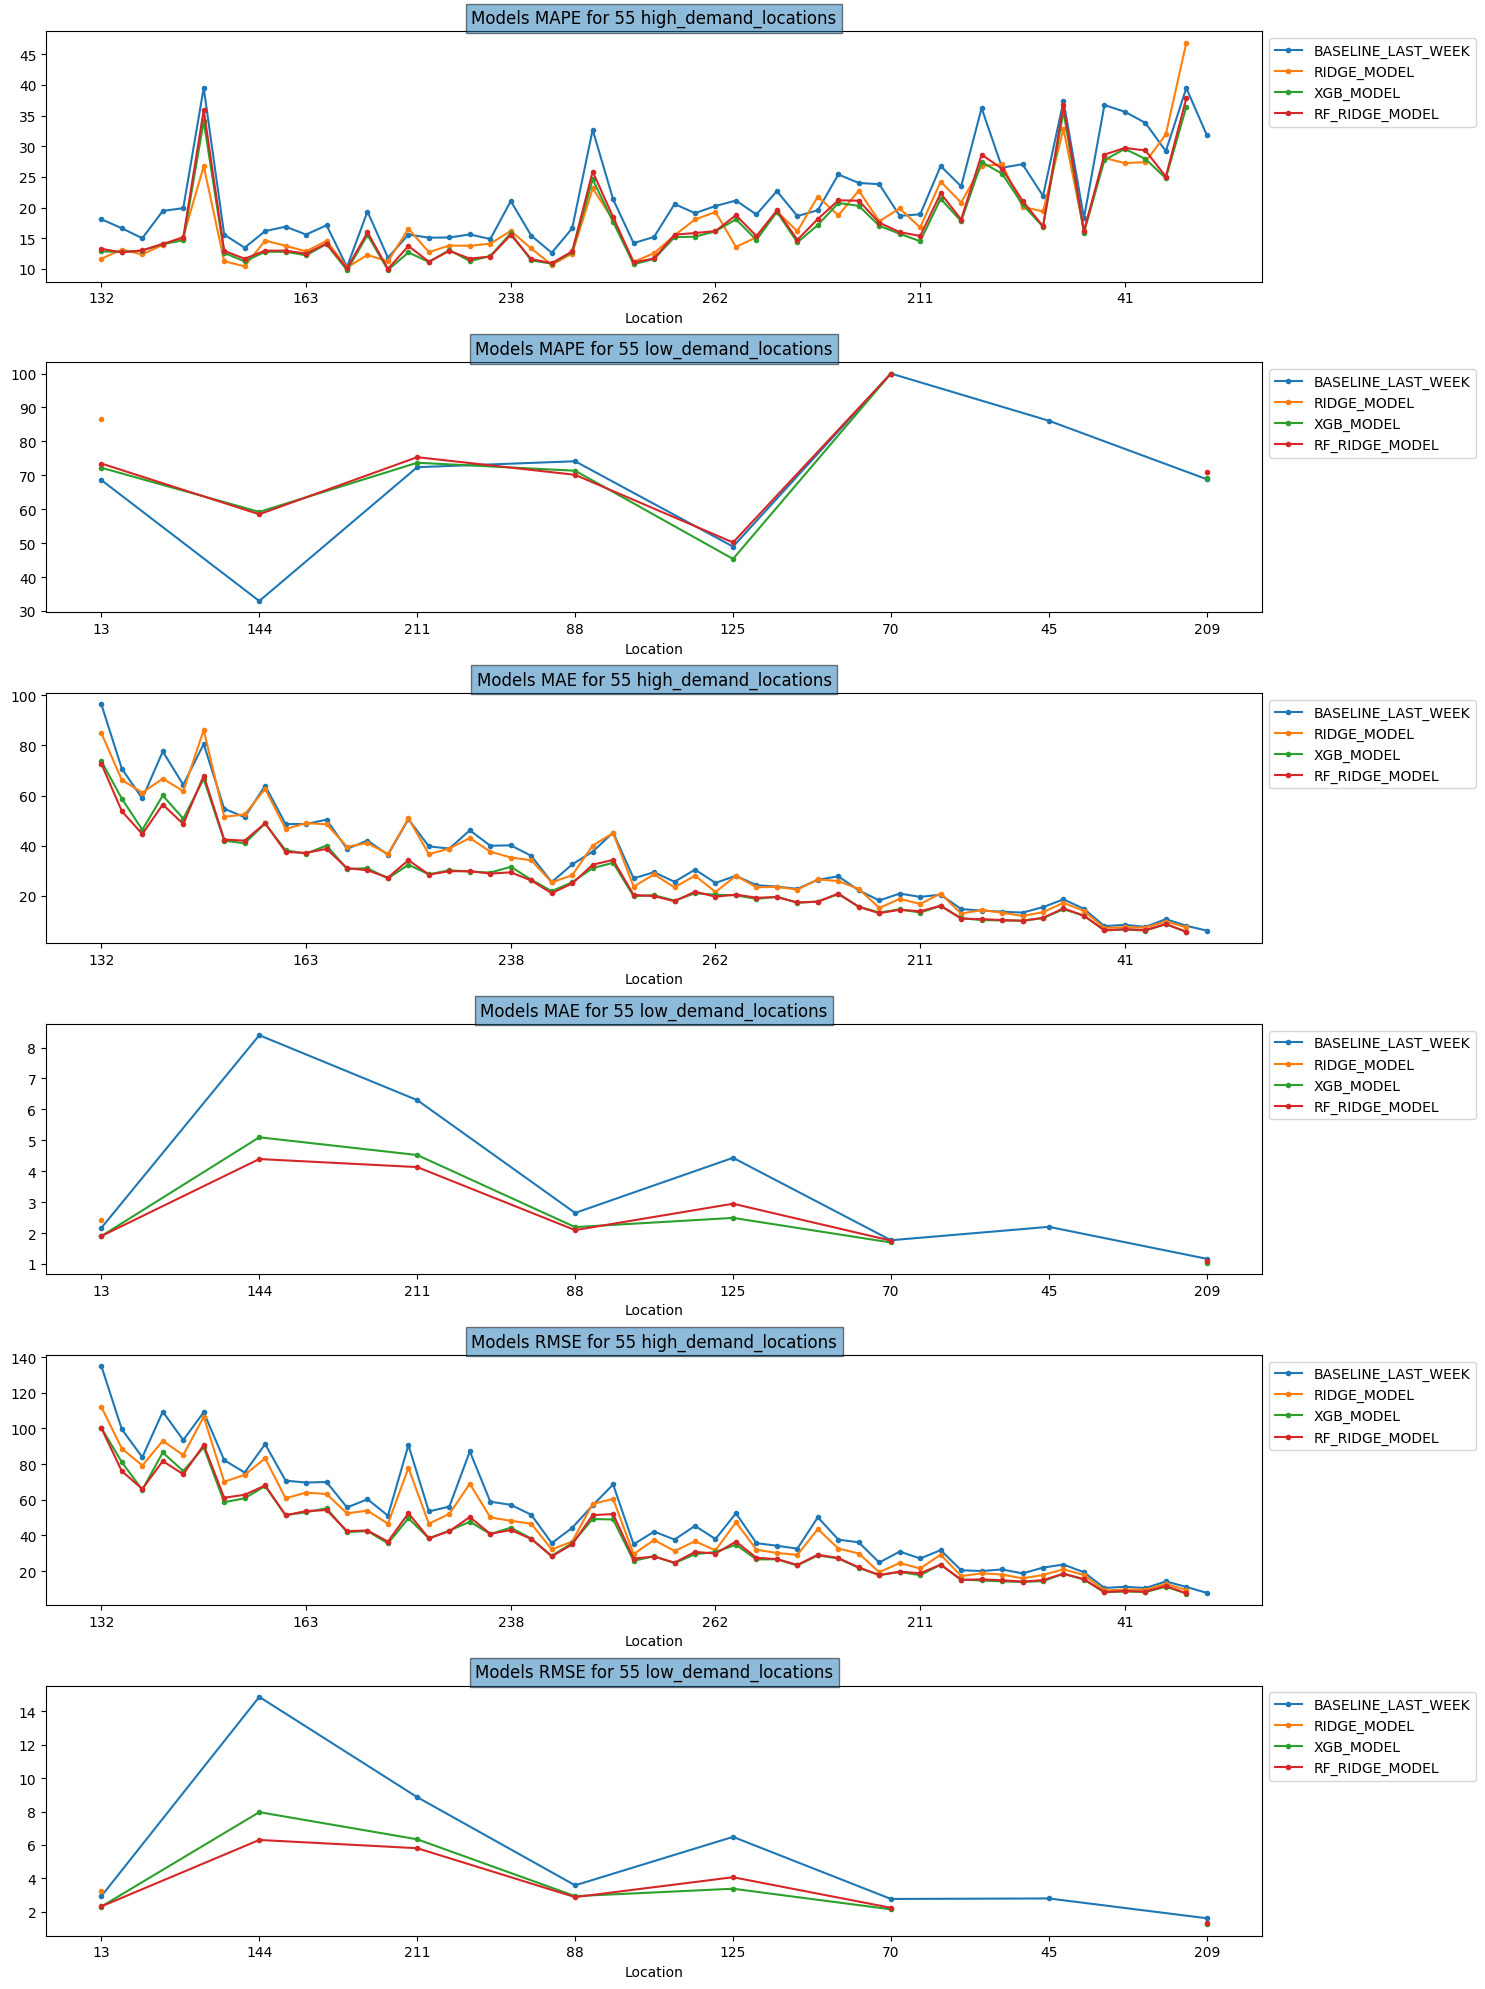

In [18]:
plot(predictions_mean_error_dict, 'Location')

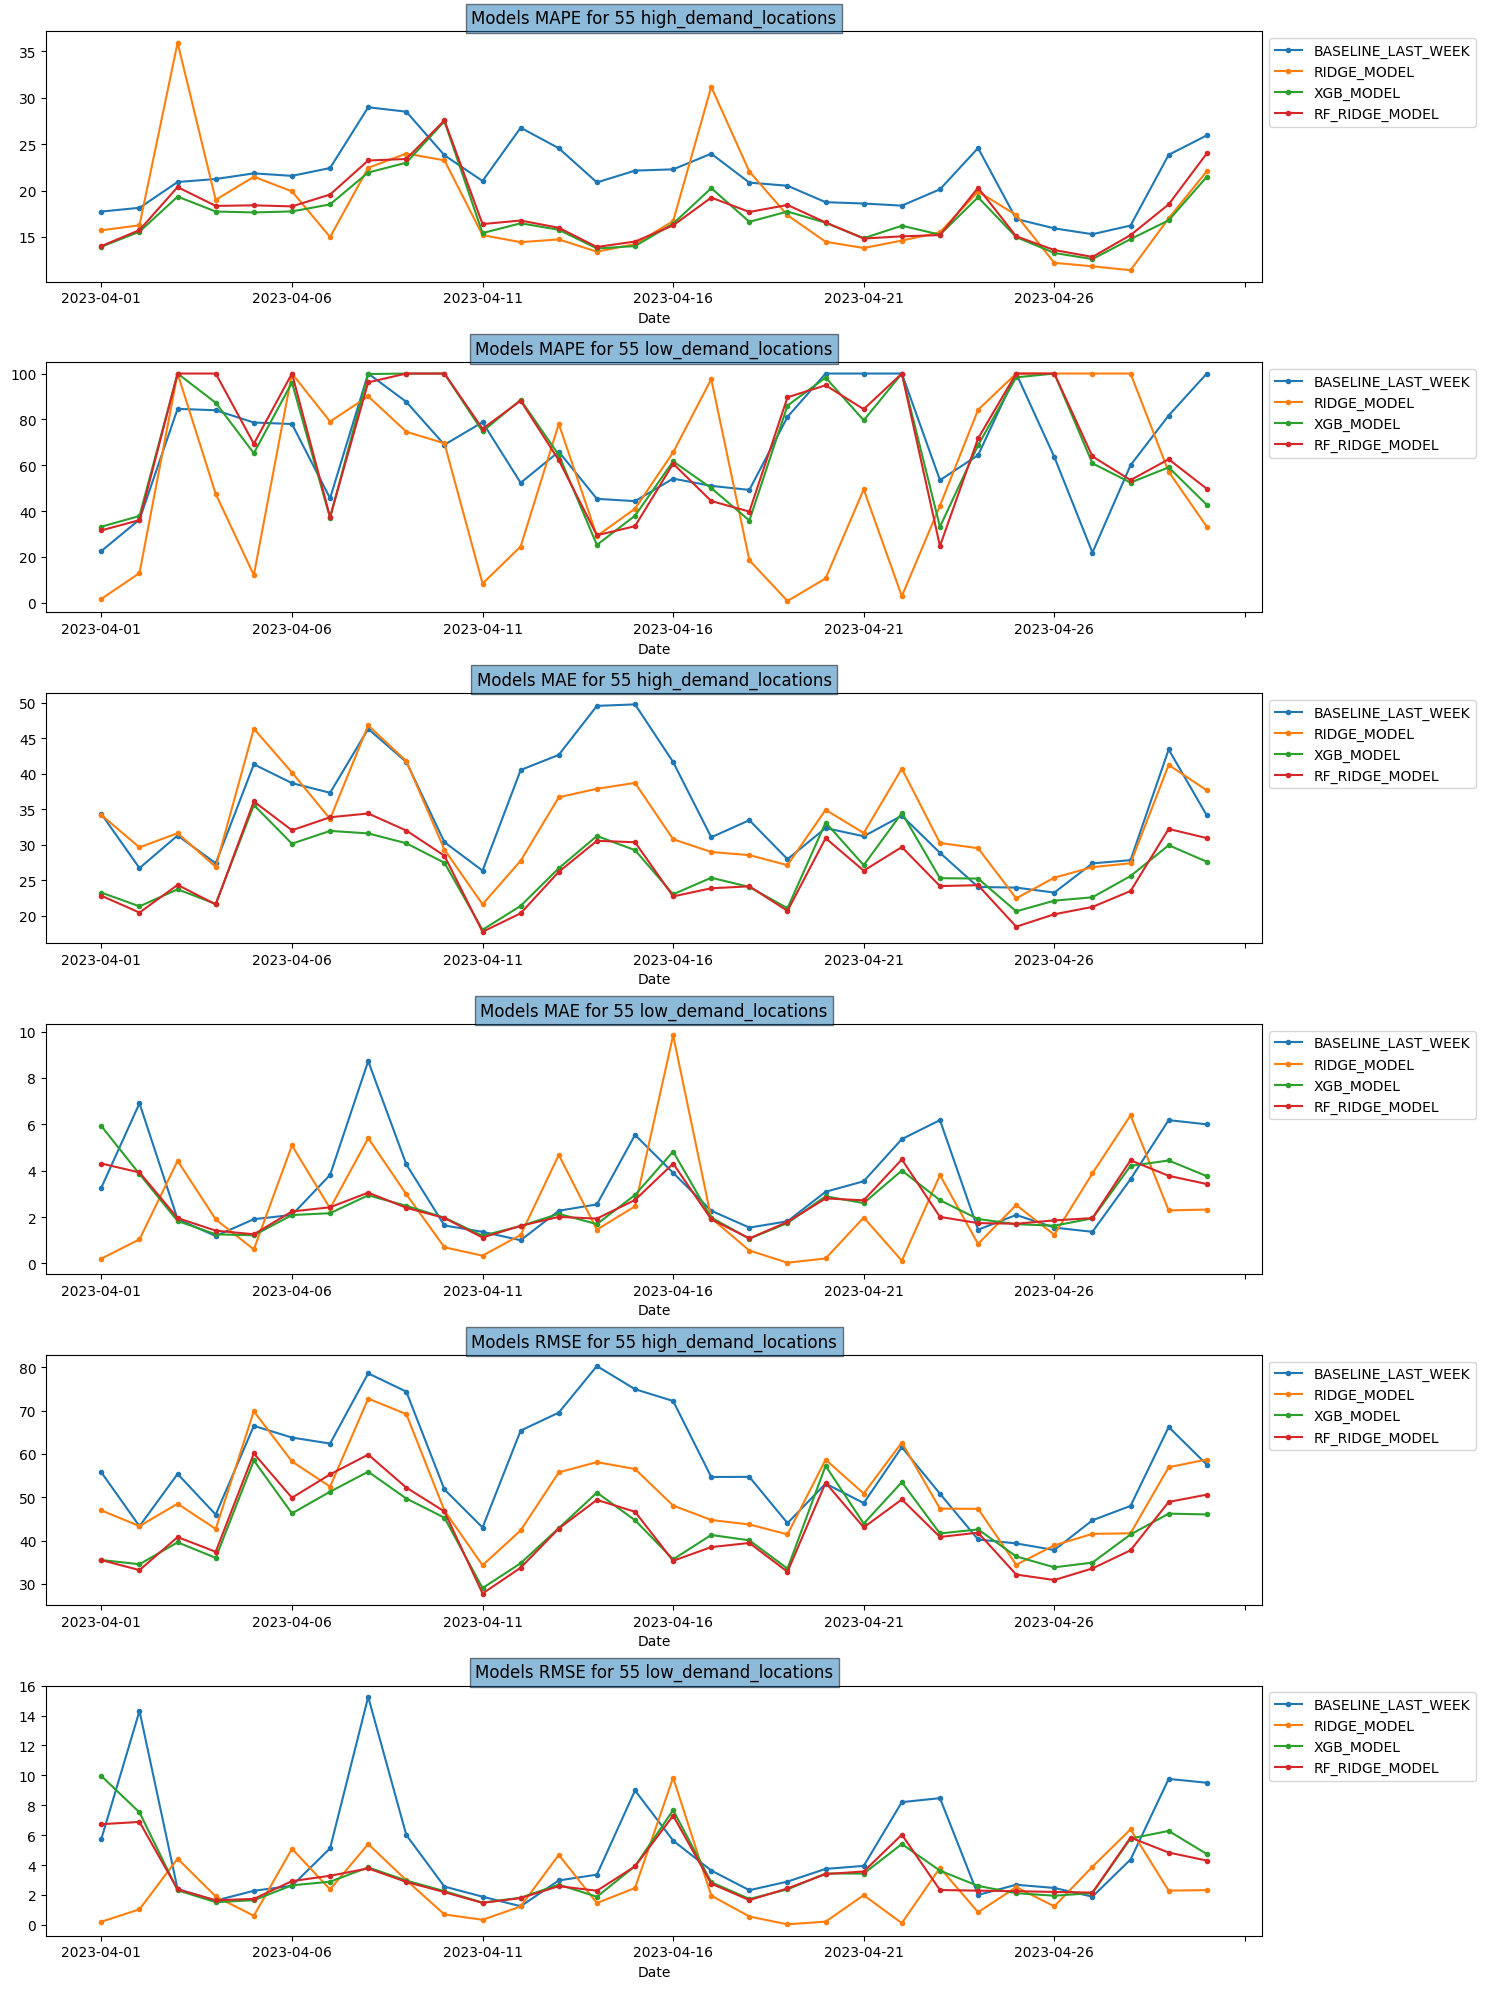

In [19]:
plot(predictions_mean_error_dict, 'Date')

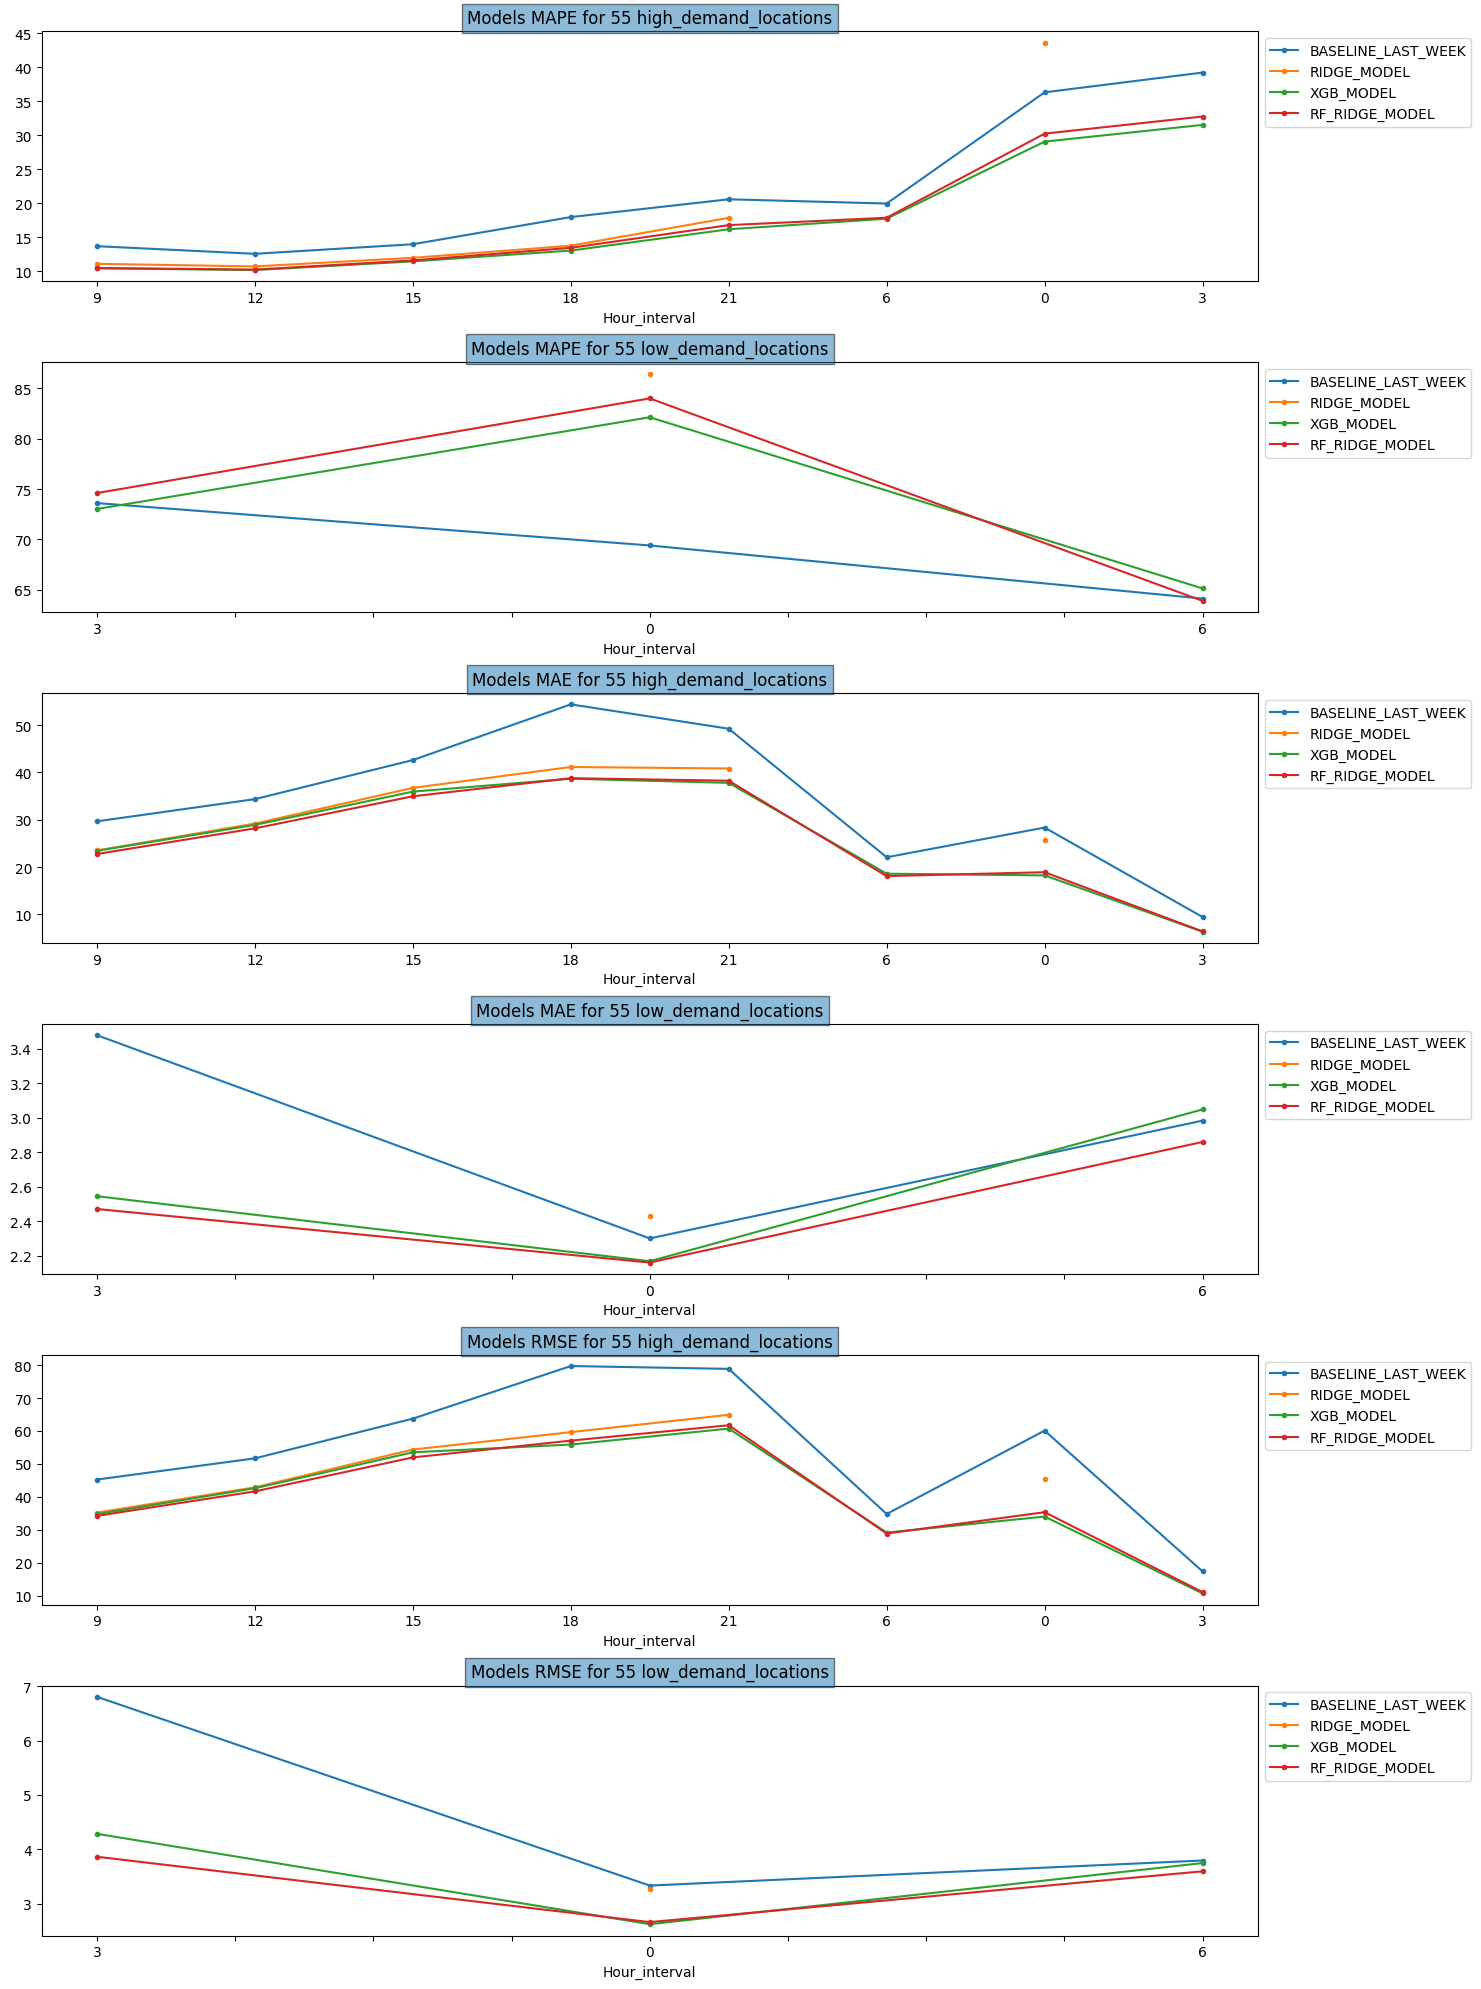

In [20]:
plot(predictions_mean_error_dict, 'Hour_interval')

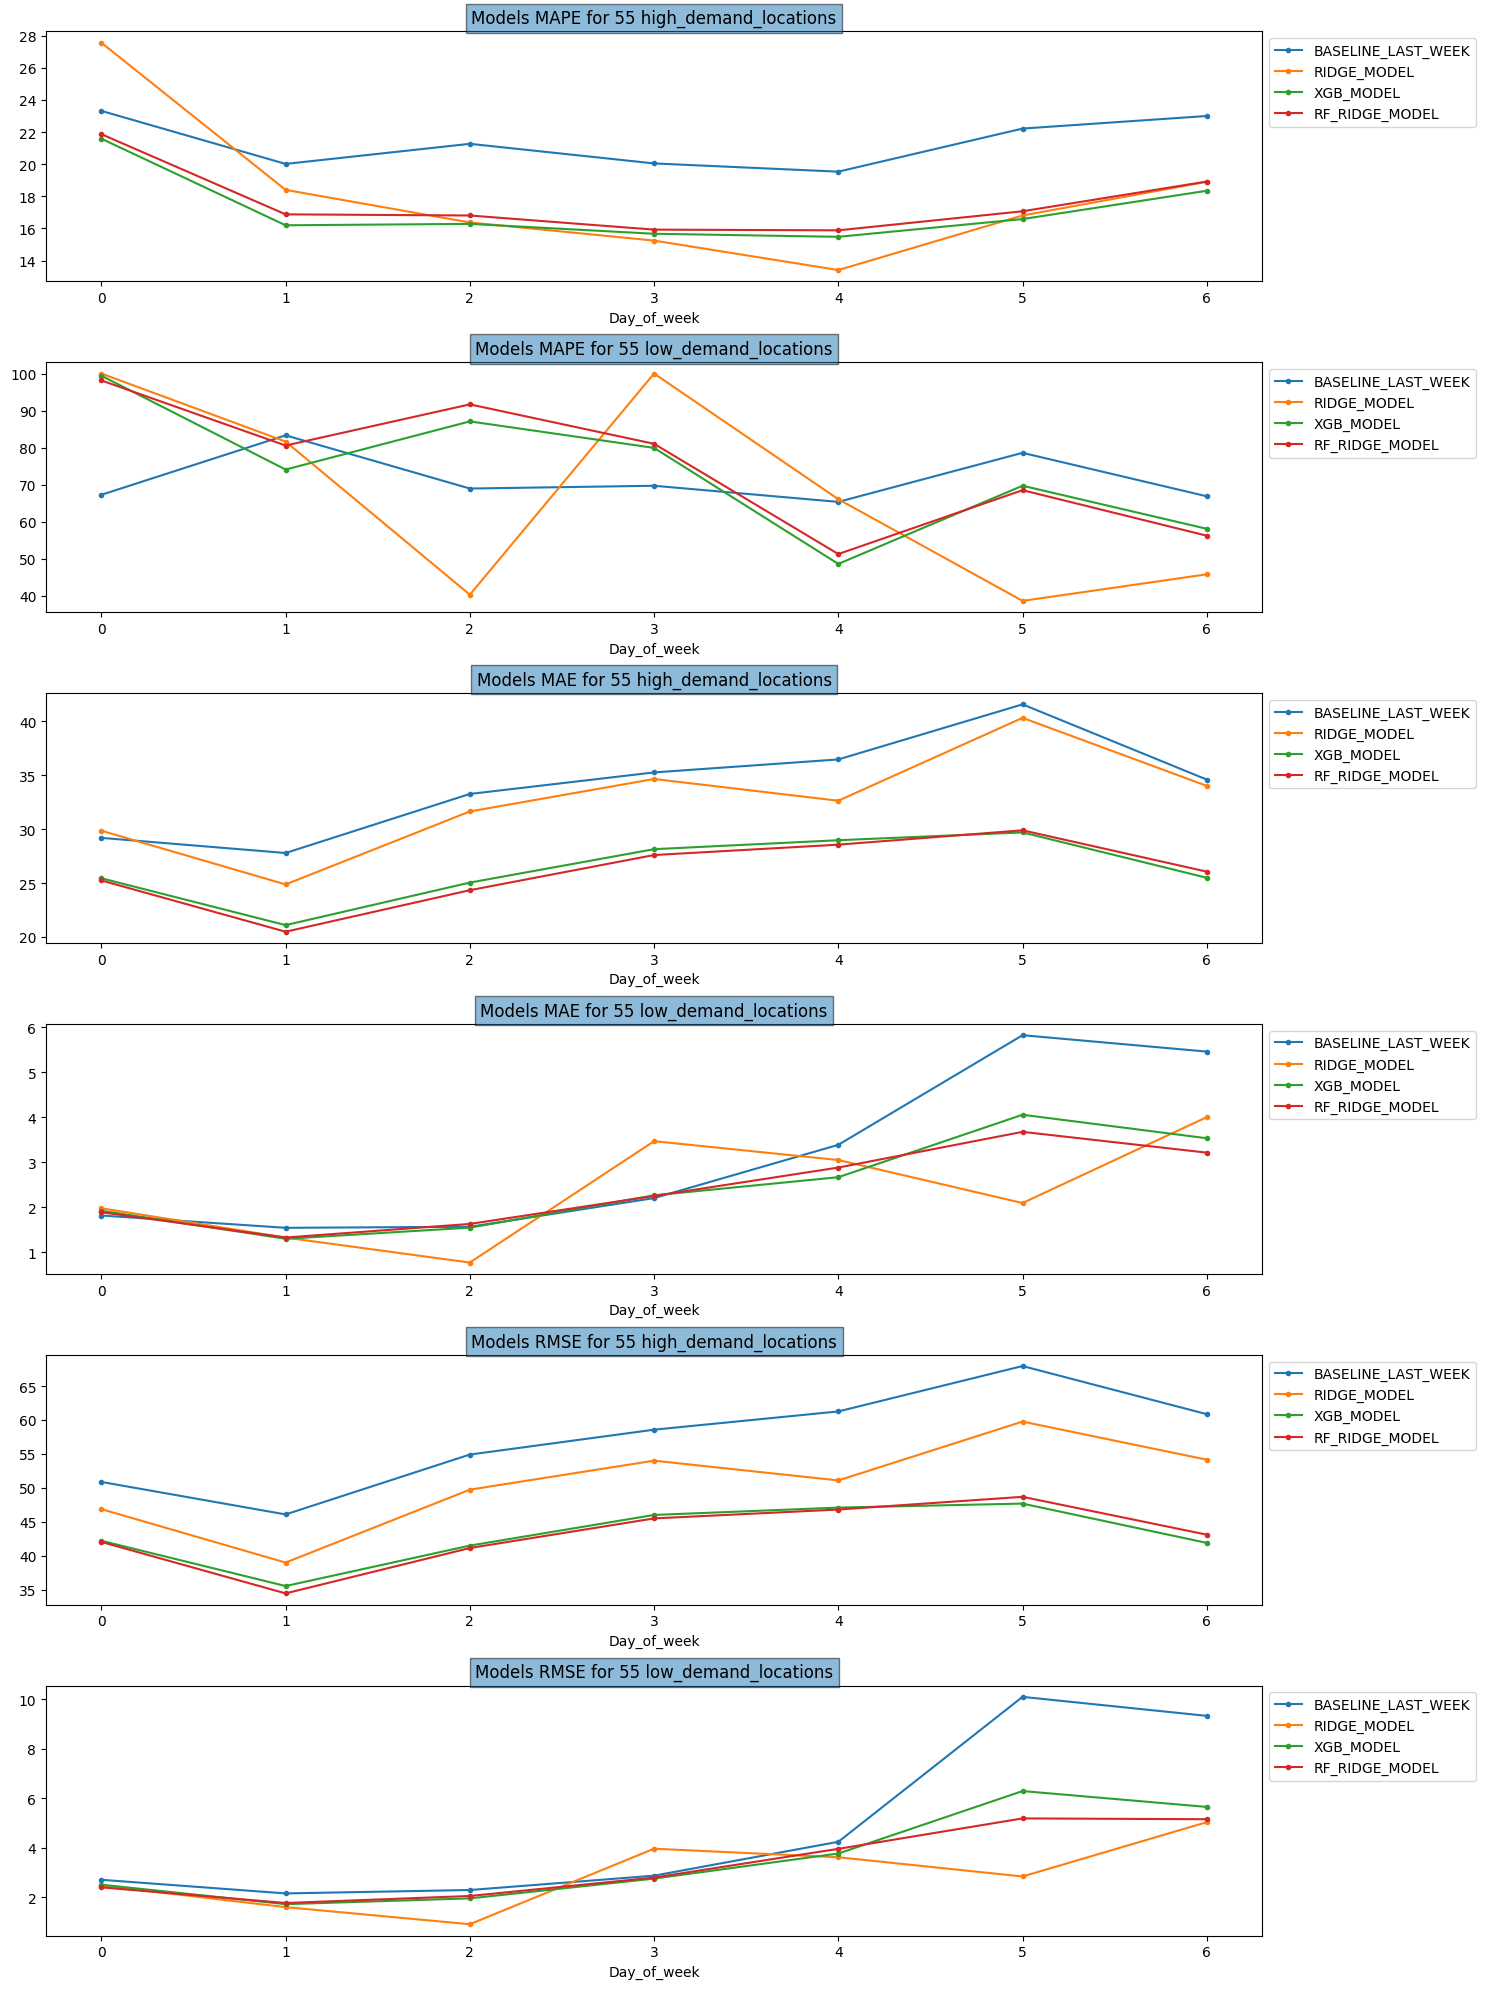

In [21]:
plot(predictions_mean_error_dict, 'Day_of_week')

# Table of Results

In [22]:
def create_table_errors(predictions_dict, report_dict):
    for model, error_df in predictions_dict.items():
        for cat in CATEGORIES:
            if error_df is not None:
                sorted_index = sorted_locations_dict[cat][['Location', 'Hour_interval']]
                categorized_df = error_df.merge(sorted_index, on=['Location','Hour_interval'])
                
                report_dict[cat]['MAE'][model] = categorized_df['error'].mean()            
                report_dict[cat]['RMSE'][model] = np.sqrt(categorized_df['squared_error'].mean())
                report_dict[cat]['MAPE'][model] = categorized_df['percentage_error'].mean()

    return report_dict

In [23]:
report_dict = create_table_errors(predictions_dict, report_dict)
report_df = pd.DataFrame.from_dict({(i,j): report_dict[i][j] 
                            for i in report_dict.keys() 
                            for j in report_dict[i].keys()},
                            orient='index')

report_df.index = pd.MultiIndex.from_tuples(report_df.index)
report_df = report_df.T

In [24]:
df = pd.DataFrame(report_df,
                  index=pd.Index(MODEL_LIST),
                  columns=pd.MultiIndex.from_product([CATEGORIES, METRICS], names=['location CATEGORIES:', 'Error Metrics:']))


In [25]:
df.style.format('{:.2f}')